In [91]:
import numpy as np
import cv2

import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
from skimage.filters.rank import entropy
from skimage.morphology import disk

In [133]:
def F(sample, K):
    
    if len(sample) != len(K):
        print("Sample and sequence length don't match")
    
    reorder = np.zeros(len(sample), dtype=np.uint8)
        
    for x in range(len(K)):
        
        reorder[K[x]] = sample[x]
    
    return reorder

#################################
# Unscramble
#################################

def invF(sample, K):
    if len(sample) != len(K):
        print("Sample and sequence length don't match")
    
    ordered = np.zeros(len(sample), dtype=np.uint8)
    
    for x in range(len(K)):
        ordered[x] = sample[K[x]]
    
    return ordered

def one_dim_bit_encrypt(image, key, order='C'):
    
    img_arr = np.array(image.flatten(order), dtype=np.uint8)
    
    len_key = len(key)
    
    encrypted_image = np.zeros(len(img.flatten()), dtype=np.uint8)
    
    for x in range(int(len(img_arr)*8/len(key))):
        
        key_len_bytes = int(len(key)/8)
        
        start = 0+(key_len_bytes*x)
        end = key_len_bytes+(key_len_bytes*x)
        
        sample = img_arr[start:end]
                
        scrambled_bits = F(np.unpackbits(sample), key)

        
        encrypted_image[start:end] = np.packbits(scrambled_bits)
        
    return encrypted_image


def one_dim_bit_decrypt(image, key, order='C'):
    
    img_arr = np.array(image.flatten(order), dtype=np.uint8)
    
    len_key = len(key)
    
    decrypted_image = np.zeros(len(img_arr.flatten()), dtype=np.uint8)
    
    for x in range(int(len(img_arr)*8/len(key))):
        
        key_len_bytes = int(len(key)/8)
        
        start = 0+(key_len_bytes*x)
        end = key_len_bytes+(key_len_bytes*x)
        
        sample = img_arr[start:end]
                
        unscrambled_bits = invF(np.unpackbits(sample), key)

        
        decrypted_image[start:end] = np.packbits(unscrambled_bits)
        
    return decrypted_image


def two_dim_bit_encrypt(image, key):
    
    height = len(image)
    width = len(image[0])    
    
    # encrypt left to right
    horiz_crypt = one_dim_bit_encrypt(image, key, order='C')
        
    #encrypt top to bottom
    vert_crypt  = one_dim_bit_encrypt(horiz_crypt.reshape((height,width)), key, order='F')
        
    return vert_crypt
    
def two_dim_bit_decrypt(image, key):
        
    vert_decrypt = one_dim_bit_decrypt(image.reshape((720,1280)), key)
    
    horiz_decrypt = one_dim_bit_decrypt(vert_decrypt.reshape((720,1280), order='F'), key)
    
    return horiz_decrypt

K = np.arange(5)
np.random.shuffle(K)
sample = [1, 2, 3, 4, 5]

def generate_key(keysize):
    key = np.arange(keysize, dtype=np.uint8)
    np.random.shuffle(key)
    return key.tolist()

scrambled = F(sample, K)
unscrambled = invF(scrambled, K)

print("Original \t" + str(sample))
print("Key \t\t" + str(K) + "\n")
print("Scrambled \t" + str(scrambled))
print("Unscrambled \t" + str(unscrambled))


key = np.arange(16)
np.random.shuffle(key)

src = 'atom32by32.png'
# src = '1.jpg'
img = cv2.imread(src,0)


crypt = two_dim_bit_encrypt(img, key).reshape((32,32))


print(np.mean(entropy(img, disk(8))))
print(np.mean(entropy(crypt, disk(8))))

# cv2.imshow('32by32 image', img)
# cv2.imshow('crypt', crypt)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

def hist_entropy(image):
    """ calculate entropy of a 8-bit grayscale image"""
    bins = [x for x in range(0,257)]
    
    hist1 = np.histogram(image, bins=bins)
    data = hist1[0]
    
    h = np.asarray(data, dtype=np.float64)
    if h.sum()<=0 or (h<0).any():
        print("[entropy] WARNING, malformed/empty input %s. Returning None."%str(hist))
        return None
    h = h/h.sum()
    return -(h*np.ma.log2(h)).sum()

def plot_hist(image, title=None, save=None):
    
    bins = [x for x in range(0,257)]

    plt.hist(image.flatten(), bins=bins)
    plt.title(title if type(title) is str else 'Image Histogram')
    plt.xlabel('8-Bit Grayscale')
    plt.ylabel('# of Occurences')
    if (type(save) is str ):
        plt.savefig(save)
    plt.show()

Original 	[1, 2, 3, 4, 5]
Key 		[3 0 1 4 2]

Scrambled 	[2 3 5 1 4]
Unscrambled 	[1 2 3 4 5]
4.957893104004805
5.807617983358645
6.102790296536192
6.791117288643924


In [170]:
def scramble_2D(image, key):
    
#     print(image)
    
    crypt_horiz = np.array([ image[i] for i in key ])
    
#     print(crypt_horiz)
    
    crypt_transpose = np.transpose(crypt_horiz)
    
#     print(crypt_transpose)
    
    crypt_vert = np.array([ crypt_transpose[i] for i in key ])
    
#     print(crypt_vert)
    
    return np.transpose(crypt_vert)

def unscramble_2D(image, key):
    
    image = np.transpose(image)
    
    crypt_vert = np.zeros((len(image), len(image[0])), dtype=np.uint8)
    
    for i in key:
        crypt_vert[key[i]] = image[i]
        
    crypt_horiz = np.transpose(crypt_vert)
    
    unscrambled = np.zeros((len(image), len(image[0])), dtype=np.uint8)
    
    for i in key:
        unscrambled[key[i]] = crypt_horiz[i]
        
    return unscrambled


def scramble_1D_bit(image, key):
    
    
    # unpackbits of 8-bit grayscale
    bits = np.unpackbits(image).reshape((len(image), len(image[0])*8))

    # tranpose to perform row shuffling
    bits_tr = np.transpose(bits)

    # iterate through each block of length key in bits
    for i in range(0, int(len(bits_tr)/len(key))):
        
        start = 0 + len(key)*i
        end = len(key) + len(key)*i
        
        # copy and rearange bits in sample based off key
        buffer = np.copy(bits_tr[start:end])
        bits_tr[start:end] = [ buffer[i] for i in key ]

    #transpose back to original image structure, pack bits
    packed = np.packbits(np.transpose(bits_tr))
    
    # reshape packed bits to original image dimensions
    return packed.reshape((len(image),len(image[0])))

def unscramble_1D_bit(image, key):
    
    # unpackbits of 8-bit grayscale
    bits = np.unpackbits(image).reshape((len(image), len(image[0])*8))

    # tranpose to perform row shuffling
    bits_tr = np.transpose(bits)
        
    # iterate through each block of length key in bits
    for i in range(0, int(len(bits_tr)/len(key))):
        
        start = 0 + len(key)*i
        end = len(key) + len(key)*i
        
        # copy and rearange bits in sample based off key
        buffer = np.copy(bits_tr[start:end])
        
        # assign bits back to original position
        for i in key:
            bits_tr[start+key[i]] = buffer[i]

    #transpose back to original image structure, pack bits
    packed = np.packbits(np.transpose(bits_tr))
    
    # reshape packed bits to original image dimensions
    return packed.reshape((len(image),len(image[0])))

def scramble_2D_bit(image, key):
    
    crypt_horiz = scramble_1D_bit(image, key)
    
    crypt_vert = scramble_1D_bit(np.transpose(crypt_horiz), key)
    
    return np.transpose(crypt_vert)

def unscramble_2D_bit(image, key):
    
    decrypt_horiz = unscramble_1D_bit(np.transpose(image), key)
    
    decrypt_vert = unscramble_1D_bit(np.transpose(decrypt_horiz), key)
    
    return decrypt_vert



def scramble(image, key, rounds):
    
    c = scramble_2D(image, key)
    cc = scramble_2D_bit(c, key)
    
    for i in range(rounds):
        c = scramble_2D(cc, key)
        cc = scramble_2D_bit(c, key)
        
    return cc
    

In [168]:
toolbox = base.Toolbox()

toolbox.register("attr_bool", generate_key, 5)
# toolbox.register("attr_bool", generate_key, 5)
# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=10)
toolbox.register("individual",tools.initIterate, creator.Individual, toolbox.attr_bool)
# toolbox.register("individual", generate_key, 5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

bit = toolbox.attr_bool()
ind = toolbox.individual()
pop = toolbox.population(n=3)



print("bit is of type %s and has value\n%s\n\n" % (type(bit), bit))
print("ind is of type %s and contains %d bits\n%s\n\n" % (type(ind), len(ind), ind))
print("pop is of type %s and contains %d individuals\n%s\n\n" % (type(pop), len(pop), pop))

bit is of type <class 'list'> and has value
[0, 1, 2, 4, 3]


ind is of type <class 'deap.creator.Individual'> and contains 5 bits
[3, 0, 4, 2, 1]


pop is of type <class 'list'> and contains 3 individuals
[[2, 4, 1, 3, 0], [0, 3, 2, 1, 4], [1, 2, 4, 0, 3]]




C:\Graham\Anaconda2\envs\gthoms\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\Graham\Anaconda2\envs\gthoms\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg    	min   	max    
0  	50    	7.94681	7.9203	7.96046
1  	30    	7.9528 	7.93301	7.96454
2  	29    	7.95623	7.92833	7.97132
3  	27    	7.95818	7.93319	7.97132
4  	35    	7.961  	7.93943	7.97132
5  	31    	7.9607 	7.92861	7.97394
6  	30    	7.96368	7.92437	7.97394
7  	30    	7.96729	7.95692	7.98131
8  	27    	7.96838	7.95192	7.98131
9  	28    	7.97088	7.95218	7.9821 
10 	36    	7.97267	7.95287	7.9821 
Best individual is: [159, 223, 235, 168, 2, 137, 174, 156, 144, 151, 17, 213, 123, 184, 124, 220, 201, 93, 153, 136, 16, 6, 101, 84, 252, 14, 45, 119, 253, 86, 204, 56, 188, 118, 120, 175, 154, 211, 147, 222, 36, 169, 176, 130, 237, 243, 191, 5, 69, 34, 203, 212, 112, 54, 170, 240, 91, 193, 194, 77, 165, 55, 127, 208, 25, 241, 158, 178, 52, 221, 80, 202, 109, 177, 96, 61, 247, 205, 11, 82, 9, 207, 234, 22, 92, 97, 138, 249, 115, 12, 166, 157, 251, 95, 129, 128, 195, 53, 19, 255, 142, 206, 113, 229, 181, 39, 131, 149, 33, 59, 88, 150, 46, 224, 173, 192, 172, 250, 67, 146, 116,

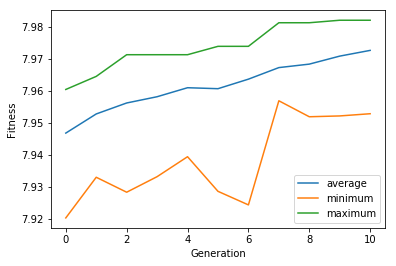

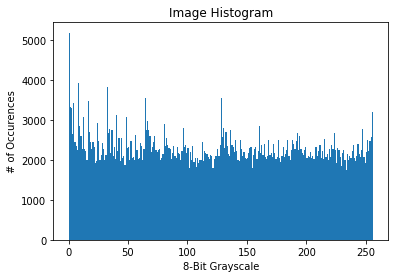

In [192]:
# src = '1.jpg'
# src = 'atom32by32.png'
src = 'flower.jpg'

img = cv2.imread(src,0)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# ind = creator.Individual([1, 0, 1, 1, 0])

toolbox = base.Toolbox()

toolbox.register("attr_bool", generate_key, 256)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_bool)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evalOneMax(individual):
    return sum(individual),

def evalEntropy(individual):
#     two_bit_crypt = two_dim_bit_encrypt(img, individual).reshape((len(img),len(img[0])))
#     score = np.mean(entropy(two_bit_crypt, disk(8)))
#     c = scramble_2D(img, individual)
    cc = scramble_2D_bit(img, individual)
    score = hist_entropy(cc)
    return score,

toolbox.register("evaluate", evalEntropy)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


def sim():
    import numpy
    
    pop = toolbox.population(n=50)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof


pop, log, hof = sim()
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

gen, avg, min_, max_ = log.select("gen", "avg", "min", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, min_, label="minimum")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

def plot_hist(image, title=None, save=None):
    
    bins = [x for x in range(0,257)]

    plt.hist(image.flatten(), bins=bins)
    plt.title(title if type(title) is str else 'Image Histogram')
    plt.xlabel('8-Bit Grayscale')
    plt.ylabel('# of Occurences')
    if (type(save) is str ):
        plt.savefig(save)
    plt.show()
    
plot_hist(scramble_2D_bit(img, hof[0]))

cv2.imshow('HOF', scramble_2D_bit(scramble_2D_bit(img, hof[0]), hof[0]))
cv2.waitKey(0)
cv2.destroyAllWindows()

In [163]:
cv2.imshow('32by32 image', two_dim_bit_encrypt(img, individual).reshape((len(img),len(img[0]))))
cv2.waitKey(0)
cv2.destroyAllWindows()

NameError: name 'individual' is not defined